In [ ]:
#@title Preparing environment

import cv2
import dlib
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import itertools

import urllib.request

from sklearn import metrics
from scipy.spatial import distance
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm,tqdm_pandas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import re
import keras

from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

warnings.filterwarnings("ignore")
def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)
    return sms

###Getting the csv data loaded
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/fer2013_5.csv"

###Getting the Dlib Shape predictor!
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/shape_predictor_68_face_landmarks.dat"

###Getting the Xpure loaded
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/pureX.npy"

###Getting the Xdata loaded
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/dataX.npy"

###Getting the Ydata loaded
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/dataY.npy"

print ("Data Downloaded!")

'''
Plots the confusion Matrix and saves it
'''
def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = list(label_map.values())
  df_cm = pd.DataFrame(cm,index = labels,columns = labels)
  fig = plt.figure()
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5,3.5,4.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  plt.show()
  plt.close()

def plot_graphs(history, best):

  plt.figure(figsize=[10,4])
  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy across training\n best accuracy of %.02f'%best[1])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss across training\n best loss of %.02f'%best[0])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

#Integer to Label Mapping
label_map = {"0":"ANGRY","1":"HAPPY","2":"SAD","3":"SURPRISE","4":"NEUTRAL"}


#Load the 68 face Landmark file
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
"""
Returns facial landmarks for the given input image path
"""
def get_landmarks(image):


  #:type image : cv2 object
  #:rtype landmarks : list of tuples where each tuple represents
  #                  the x and y co-ordinates of facial keypoints

  #Bounding Box co-ordinates around the face(Training data is 48*48(cropped faces))
  rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]

  #Read Image using OpenCV
  #image = cv2.imread(image_path)
  #Detect the Faces within the image
  landmarks = [(p.x, p.y) for p in predictor(image, rects[0]).parts()]
  return image,landmarks

"""
Display image with its Facial Landmarks
"""
def image_landmarks(image,face_landmarks):
  """
  :type image_path : str
  :type face_landmarks : list of tuples where each tuple represents
                     the x and y co-ordinates of facial keypoints
  :rtype : None
  """
  radius = -4
  circle_thickness = 1
  image_copy = image.copy()
  for (x, y) in face_landmarks:
    cv2.circle(image_copy, (x, y), circle_thickness, (255,0,0), radius)

  plt.imshow(image_copy, interpolation='nearest')
  plt.show()

"""
Computes euclidean distance between 68 Landmark Points for our features
e_dist is a list of features that will go into our model.
Each feature is a distance between two landmark points, and every pair of points
must have a feature.
"""

def landmarks_edist(face_landmarks):
    e_dist = []
    for i,j  in itertools.combinations(range(68), 2):
      e_dist.append(distance.euclidean(face_landmarks[i],face_landmarks[j]))
    return e_dist

def compare_learning(mlp, lm, cnn, vgg):

  # summarize history for accuracy
  plt.plot(vgg.history['val_accuracy'],)
  plt.plot(cnn.history['val_accuracy'])
  plt.plot(mlp.history['val_accuracy'],)
  plt.plot(lm.history['val_accuracy'])
  plt.ylabel('validitation accuracy')
  plt.xlabel('epoch')
  plt.legend(['cnn_transfer', 'cnn_scratch', 'mlp_pixels', 'mlp_landmarks'], bbox_to_anchor=[1,1])
  plt.xticks(range(0, epochs+1, 5), range(0, epochs+1, 5))
  plt.show()


fer2013_5.csv       100%[===================>] 159.97M  89.3MB/s    in 1.8s    
shape_predictor_68_ 100%[===================>]  95.08M  85.0MB/s    in 1.1s    
pureX.npy           100%[===================>]  43.95M  76.6MB/s    in 0.6s    
dataX.npy           100%[===================>] 347.59M  17.7MB/s    in 5.8s    
dataY.npy           100%[===================>] 156.38K  --.-KB/s    in 0.002s  
Data Downloaded!


In [ ]:
# initialize the model
tmp_model = Sequential()

# add a "Dense" (i.e. fully connected) layer
tmp_model.add(Dense(7, input_shape=(5,), activation = 'relu')) # for the first layer we specify the input dimensions

# have to add another layer
tmp_model.add(Dense(7, activation = 'relu'))

# defining the output layer, which has the number of dimensions of the predictions we're making
tmp_model.add(Dense(4, activation = 'softmax'))

# compiling it and defining some other hyperparameters
tmp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#@title Test model
# initialize the model
tmp_model_answer = Sequential()

# add a Dense layer
tmp_model_answer.add(Dense(7, input_shape=(5,), activation = 'relu')) # for the first layer we specify the input dimensions

# have to add another layer
tmp_model_answer.add(Dense(7, activation = 'relu'))

# defining the output layer, which has the number of dimensions of the predictions we're making
tmp_model_answer.add(Dense(4, activation = 'softmax'))

# compiling it and defining some other hyperparameters
tmp_model_answer.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


tmp_model_config = tmp_model.get_config()

del tmp_model_config["name"]
for layer in tmp_model_config["layers"]:
  del layer["config"]["name"]

tmp_model_answer_config = tmp_model_answer.get_config()

del tmp_model_answer_config["name"]
for layer in tmp_model_answer_config["layers"]:
  del layer["config"]["name"]

if tmp_model_answer_config == tmp_model_config:
  print('Good job! Your model worked')
else:
  print('Please check your code again!')

Good job! Your model worked


In [ ]:
perceptron = Sequential()

# add a Dense layer
perceptron.add(Dense(1024, input_shape=(2278,), activation = 'relu', kernel_initializer='glorot_normal')) # for the first layer we specify the input dimensions

# add another layer
perceptron.add(Dense(512, activation = 'relu', kernel_initializer='glorot_normal'))

# defining the output layer, which has the number of dimensions of the predictions we're making
perceptron.add(Dense(5, activation = 'softmax'))

# compiling it and defining some other hyperparameters
perceptron.compile(loss='categorical_crossentropy', optimizer = SGD(learning_rate=0.001), metrics=['accuracy'])


In [ ]:
#@title Test
perceptron_answer = Sequential()
perceptron_answer.add(Dense(1024, input_shape = (2278,),kernel_initializer='glorot_normal',activation = 'relu'))
perceptron_answer.add(Dense(512,kernel_initializer='glorot_normal' , activation = 'relu'))
perceptron_answer.add(Dense(5, activation = 'softmax'))

perceptron_answer.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001), metrics=['accuracy'])

if model_to_string(perceptron) == model_to_string(perceptron_answer):
  print('Good job, you specified it correctly!')
else:
  print('Please check your code again!')

Good job, you specified it correctly!


###Set some hyper parameters for all models

In [ ]:
# the number of times we pass all the training data through the model
epochs = 20
# the number of examples we pass to the model at each time
batch_size = 16
# the proportion of testing data we set aside (e.g. 10%)
test_ratio = .1
# the number of emotion categories we have to predict
n_labels = 5

Load the original (unprocessed) data

In [ ]:
# load data
dataX_pixels = np.load('pureX.npy')
dataY_labels = np.load('dataY.npy')

### Convert labels to one-hot encoded labels

One hot encoding is a representation of categorical variables as binary vectors

In [ ]:
# convert labels to one hot encoding
y_onehot = to_categorical(dataY_labels, len(set(dataY_labels)))

###Split and Standardize your Data



In [ ]:
# split Data into Train, Test (90-10)
X_train, X_test, y_train, y_test = train_test_split(dataX_pixels, y_onehot, test_size=test_ratio, random_state=42)

#### Standardize the data ##########
pixel_scaler = StandardScaler()
pixel_scaler.fit(X_train)
X_train = pixel_scaler.transform(X_train)
X_test = pixel_scaler.transform(X_test)

In [ ]:
# Modify input shape to match the actual input data
def build_mlp_model(input_shape, num_classes):
    model = Sequential()

    # Input layer, adjust to match the actual input shape (2304)
    model.add(Dense(128, input_shape=(input_shape,), activation='relu'))

    # Rest of the layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(num_classes, activation='softmax'))  # Output layer

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Assuming input shape is 2304
input_shape = 2304
num_classes = 5

mlp_model = build_mlp_model(input_shape, num_classes)
mlp_model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                     │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,541 (1.17 MB)

 Trainable params: 305,541 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compiling the model with SGD optimizer and categorical crossentropy loss
mlp_model.compile(loss=categorical_crossentropy, optimizer=SGD(learning_rate=0.001), metrics=['accuracy'])

#Saves the Best Model Based on Val Loss
checkpoint = ModelCheckpoint('best_mlp_model.keras', verbose=1, monitor='val_loss', save_best_only=True,  mode='auto')

#training the model
mlp_history = mlp_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
                            callbacks=[checkpoint], validation_data=(X_test, y_test), shuffle=True)

Epoch 1/20
1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2172 - loss: 1.9004
Epoch 1: val_loss improved from inf to 1.57640, saving model to best_mlp_model.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.2173 - loss: 1.9001 - val_accuracy: 0.2960 - val_loss: 1.5764
Epoch 2/20
1094/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2534 - loss: 1.6263
Epoch 2: val_loss improved from 1.57640 to 1.55780, saving model to best_mlp_model.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2533 - loss: 1.6261 - val_accuracy: 0.3135 - val_loss: 1.5578
Epoch 3/20
1110/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2659 - loss: 1.5918
Epoch 3: val_loss improved from 1.55780 to 1.53959, saving model to best_mlp_model.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2659 - loss: 1.5917 - val_accuracy: 0.3260 - val_loss: 1.5396
Epoch 4/20
1108/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2825 - loss: 1.5673
Epoch 4: val_loss improved f

###Evaluate best model

In [ ]:
mlp_performance = mlp_model.evaluate(X_test, y_test, batch_size=64)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4278 - loss: 1.4122


###Visualize accuracy and loss over training + display best model's performance

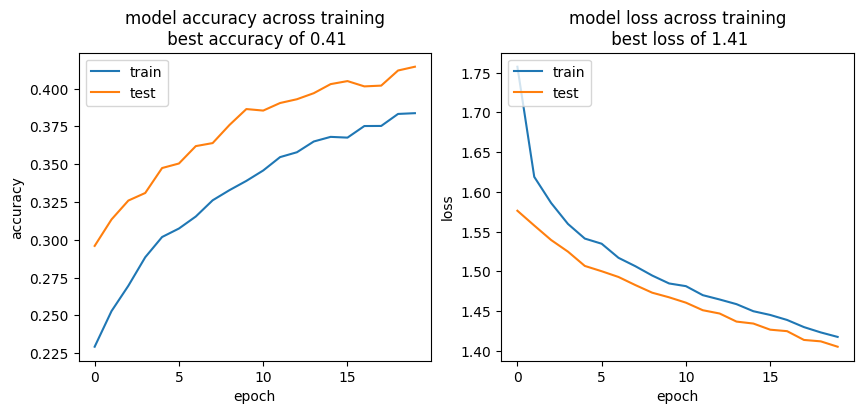

In [ ]:
plot_graphs(mlp_history, mlp_performance);

###Plot the Confusion Matrix

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Plotting the Confusion Matrix


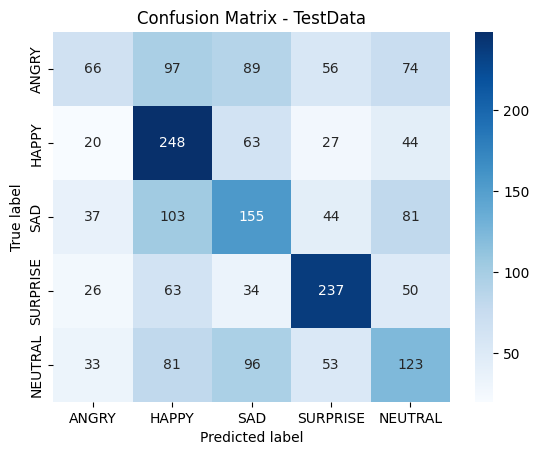

In [ ]:
y_pred_mlp = mlp_model.predict(X_test)
y_pred_mlp_classes = np.argmax(y_pred_mlp, axis=1)
y_true = np.argmax(y_test,axis=1)
plot_confusion_matrix(y_true, y_pred_mlp_classes)

##Neural Network Model Evaluation on distance inputs

In [ ]:
#Load the data (Distances between facial Landmarks)
dataX_lm = np.load('./dataX.npy')

# split Data into Train, Test (90-10)
X_train_lm, X_test_lm, y_train_lm, y_test_lm = train_test_split(dataX_lm, y_onehot, test_size=0.1, random_state=42)

#### Standardize the data #####
lm_scaler = StandardScaler()
lm_scaler.fit(X_train_lm)
X_train_lm = lm_scaler.transform(X_train_lm)
X_test_lm = lm_scaler.transform(X_test_lm)

In [ ]:
lm_model= Sequential()
lm_model.add(Dense(1024, input_shape=(2278,), activation = 'relu', kernel_initializer='glorot_normal'))
lm_model.add(Dense(1024, activation= "relu", kernel_initializer='glorot_normal'))
lm_model.add(Dropout(0.5))
lm_model.add(Dense(5, activation = 'softmax'))

In [ ]:
# Compiling the model with SGD optimizer and categorical crossentropy loss
lm_model.compile(loss=categorical_crossentropy, optimizer=SGD(learning_rate=0.001), metrics=['accuracy'])

#Saves the Best Model Based on Val Loss
checkpoint = ModelCheckpoint('best_lm_model.keras', verbose=1, monitor='val_loss', save_best_only=True,  mode='auto')
#training the model
lm_history = lm_model.fit(X_train_lm, y_train_lm, batch_size=batch_size, epochs=epochs,
                          verbose=1, callbacks=[checkpoint], validation_data=(X_test_lm, y_test_lm), shuffle=True)

Epoch 1/20
1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3659 - loss: 1.5488
Epoch 1: val_loss improved from inf to 1.25362, saving model to best_lm_model.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3662 - loss: 1.5481 - val_accuracy: 0.4845 - val_loss: 1.2536
Epoch 2/20
1099/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4677 - loss: 1.2989
Epoch 2: val_loss improved from 1.25362 to 1.21922, saving model to best_lm_model.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4679 - loss: 1.2986 - val_accuracy: 0.4980 - val_loss: 1.2192
Epoch 3/20
1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4922 - loss: 1.2522
Epoch 3: val_loss improved from 1.21922 to 1.19001, saving model to best_lm_model.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4922 - loss: 1.2520 - val_accuracy: 0.5120 - val_loss: 1.1900
Epoch 4/20
1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5135 - loss: 1.1998
Epoch 4: val_loss improved fro

In [ ]:
#Evaluate model
lm_performance = lm_model.evaluate(X_test_lm, y_test_lm, batch_size=64)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5565 - loss: 1.1114


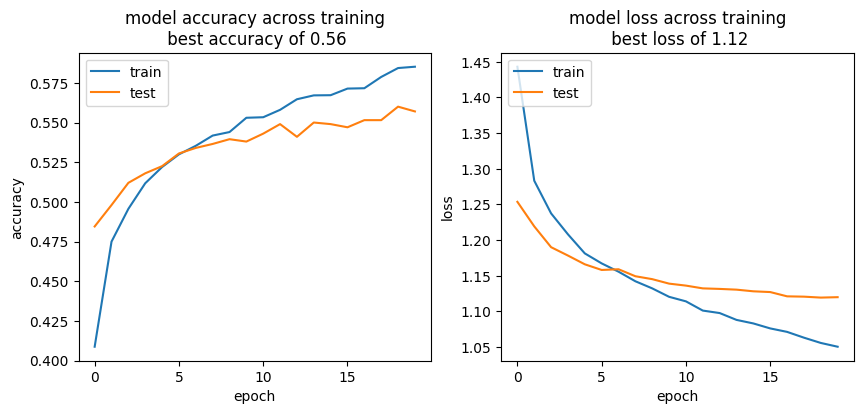

In [ ]:
#Visualise accuracy

# Plot the accuracy and loss curves for the lm_model
plot_graphs(lm_history, lm_performance)

###Model Hyperparameters

In [ ]:
# same epochs and batch size as above
width, height = 48, 48

###Reshape the inputs

In [ ]:
# pixels were vectors
print(X_train.shape)

(18000, 2304)


In [ ]:
X_train_cnn = X_train.reshape(len(X_train),height,width)
X_test_cnn = X_test.reshape(len(X_test),height,width)

# convert to images
print(X_train_cnn.shape)
# add one more dimension for model compatibility
print(X_test_cnn.shape)


(18000, 48, 48)
(2000, 48, 48)


In [ ]:
# one more dimension for model compatibility
X_train_cnn = np.expand_dims(X_train_cnn,3)
X_test_cnn = np.expand_dims(X_test_cnn,3)

print(X_train_cnn.shape)

(18000, 48, 48, 1)


CNN model

In [ ]:
# initialize model
cnn_model = Sequential()
# this conv layer has 64 filters: the input shape needs to be the same dimensions of the image
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1)))
# batch normalization
cnn_model.add(BatchNormalization())
# max pooling
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# dropout
cnn_model.add(Dropout(0.5))



# flatten all the outputs between convolutional and dense layers
cnn_model.add(Flatten())
# add a "dense layer" (i.e. the fully connected layers in MLPs) with dropout
cnn_model.add(Dense(512, activation='relu'))
# output layer
cnn_model.add(Dense(n_labels, activation='softmax'))

In [ ]:
#Saves the Best Model Based on Val Loss
checkpoint = ModelCheckpoint('best_cnn_model.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

# compliling the model with adam optimizer and categorical crossentropy loss
cnn_model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])

# training the model
cnn_history = cnn_model.fit(X_train_cnn, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
                            callbacks=[checkpoint], validation_data=(X_test_cnn, y_test), shuffle=True)

Epoch 1/20
1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3736 - loss: 2.8791
Epoch 1: val_loss improved from inf to 1.32581, saving model to best_cnn_model.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.3737 - loss: 2.8760 - val_accuracy: 0.4490 - val_loss: 1.3258
Epoch 2/20
1122/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4914 - loss: 1.2231
Epoch 2: val_loss improved from 1.32581 to 1.26421, saving model to best_cnn_model.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.4914 - loss: 1.2231 - val_accuracy: 0.4885 - val_loss: 1.2642
Epoch 3/20
1120/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5520 - loss: 1.1002
Epoch 3: val_loss improved from 1.26421 to 1.22796, saving model to best_cnn_model.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.5520 - loss: 1.1003 - val_accuracy: 0.5175 - val_loss: 1.2280
Epoch 4/20
1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6047 - loss: 0.9852
Epoch 4: val_loss impr

###Evaluate the model

In [ ]:
cnn_performance = cnn_model.evaluate(X_test_cnn, y_test, batch_size=64)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5572 - loss: 1.9417


###Plot Accuracy and Loss

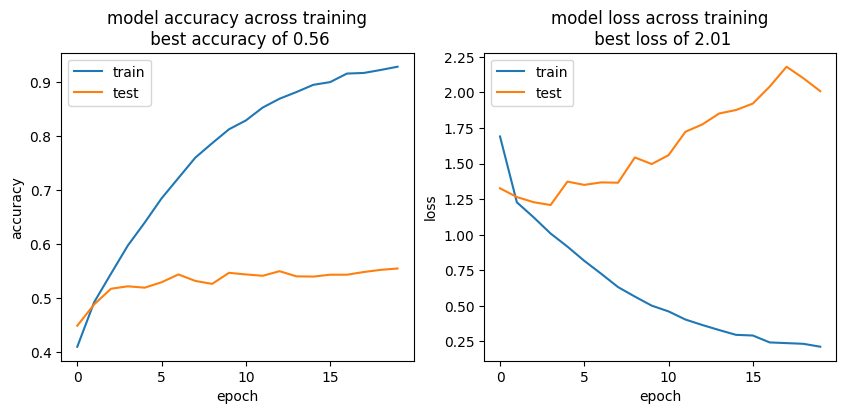

In [ ]:
plot_graphs(cnn_history, cnn_performance)

# Finished :D